<a href="https://colab.research.google.com/github/maxmatical/MATLAB/blob/master/Yamana_Case_v4_Test_1_Max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps taken in this notebook

1. use all features (excluding the highly correlated ones)
2. try LR and RF (tuned)
    - add feature importance
3. Try steps 1 and 2 on the dataset after dropping missing target values


## New idea
Try using shap https://github.com/slundberg/shap for model interpretation

## Values below detection limit
- Currently just removing the "<"
- Future steps:
    - Separate values below detection limit into another df
    - Use half the detection limit value or use other methods to estimate values
    - concatenate together to get full df

In [0]:
# Set up environment and download course-v3
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install fastprogress
!pip install pathlib

!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
!pip install scikit-optimize
!pip install shap


In [0]:
from fastai import *
from fastai.tabular import *

import pandas as pd
import matplotlib as plt
import numpy as np

In [0]:
import matplotlib.pyplot as plt


In [0]:
import shap

In [0]:
from xgboost import XGBClassifier, XGBRegressor

# Using imputed values (median) for target variables

In [0]:
path = '/content/data/'
os.makedirs(path, exist_ok=True)
fname = 'Base de Datos Geometalurgia Goldspot'
#path

for some reason 



```
df = pd.read_csv(f'{path}/{name}.csv', low_memory=False)
```

is causing colab issues and cannot load


In [0]:
df = pd.read_csv('/content/data/Base de Datos Geometalurgia Goldspot.csv', low_memory=False)

In [0]:
df.head(5)

,compid,dhid,midx,midy,midz,topx,topy,topz,botx,boty,...,Te,Th,Ti,Tl,U,V,W,Y,Zn,Zr
0,CAN,OF07482,449967.09,7301211.35,1819.01,449967.61,7301211.40,1819.01,449966.56,7301211.31,...,-99,-99,-99,-99,-99,-99.0,-99,-99,-99,-99.0
1,CAN,OF07491,449950.70,7301374.94,1836.81,449949.32,7301375.18,1836.81,449952.08,7301374.70,...,-99,-99,-99,-99,-99,-99.0,-99,-99,-99,-99.0
2,CAN,OF07505,449950.06,7301418.56,1836.86,449949.61,7301418.52,1836.86,449950.50,7301418.60,...,-99,-99,-99,-99,-99,-99.0,-99,-99,-99,-99.0
3,CAN,OF08219,449896.24,7301571.17,1677.28,449895.20,7301571.08,1677.28,449897.29,7301571.26,...,-99,-99,-99,-99,-99,-99.0,-99,-99,-99,-99.0
4,CAN,OF08222,449906.02,7301433.32,1601.00,449905.37,7301433.32,1601.00,449906.67,7301433.32,...,-99,-99,24,-99,-99,-99.0,3,-99,1000,-99.0


### Preprocessing
1. remove any instances of ">", "<", and "," from the data
2. Impute (or remove) any instances of -99 for 'agrec' or 'nacnc'
    - if imputing: use median value 
3. Change any instance of -99 in features to be np.nan (to use FillMissing)
4. use FillMissing to change NaN to -99, and add feature for var_na (bool)
5. Perform analysis on features to see if any features (other than top/mid/bot) are correlated, remove those variables from the modelling process
    - https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
6. Split features into 3 dataframes: 
    - Just geo data
    - Just geochemical data
    - both
7. Model using features, see what kind of results we get with subset of the features
8. Perform any feature importance analysis as needed

In [0]:
# stripping all str columns of > and < symbols
for column in df.columns:
    if df[column].dtype == 'O' and column != 'compid' and column != 'dhid':
        df[column] = df[column].map(lambda x: x.lstrip('>,<'))
        df[column] = df[column].str.replace(',','.')
        df[column] = df[column].astype(float)



In [0]:
df['nacnc'] = df['nacnc'].replace(-99,df['nacnc'].median(), inplace = False)

df['agrec'] = df['agrec'].replace(-99,df['agrec'].median(), inplace = False)

In [0]:
df = df.replace(-99, np.nan, inplace=False)


In [0]:
cat_names = ['geocod', 'bound']
cont_names = ['midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz',
             'length', 'from', 'to','auppm', 'agppm', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se', 'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr']

In [0]:
fillmissing = FillMissing(cat_names = cat_names, cont_names = cont_names, fill_strategy='CONSTANT', fill_val = -99.0)


In [0]:
fillmissing(df)

In [0]:
df.head(10)

,compid,dhid,midx,midy,midz,topx,topy,topz,botx,boty,...,Te_na,Th_na,Ti_na,Tl_na,U_na,V_na,W_na,Y_na,Zn_na,Zr_na
0,CAN,OF07482,449967.09,7301211.35,1819.01,449967.61,7301211.40,1819.01,449966.56,7301211.31,...,True,True,True,True,True,True,True,True,True,True
1,CAN,OF07491,449950.70,7301374.94,1836.81,449949.32,7301375.18,1836.81,449952.08,7301374.70,...,True,True,True,True,True,True,True,True,True,True
2,CAN,OF07505,449950.06,7301418.56,1836.86,449949.61,7301418.52,1836.86,449950.50,7301418.60,...,True,True,True,True,True,True,True,True,True,True
3,CAN,OF08219,449896.24,7301571.17,1677.28,449895.20,7301571.08,1677.28,449897.29,7301571.26,...,True,True,True,True,True,True,True,True,True,True
4,CAN,OF08222,449906.02,7301433.32,1601.00,449905.37,7301433.32,1601.00,449906.67,7301433.32,...,True,True,False,True,True,True,False,True,False,True
5,CAN,OF08223,449940.31,7301543.05,1773.45,449940.01,7301543.08,1773.45,449940.61,7301543.03,...,True,True,True,True,True,True,True,True,True,True
6,CAN,OF08264,449922.79,7301652.09,1854.98,449921.08,7301651.73,1854.98,449924.50,7301652.46,...,True,True,False,True,True,True,False,True,False,True
7,CAN,OF08306,449933.71,7301556.51,1773.12,449933.33,7301556.19,1773.12,449934.10,7301556.83,...,True,True,False,True,True,True,False,True,False,True
8,CAN,OF08389,449872.89,7301556.36,1600.87,449871.73,7301556.05,1600.87,449874.05,7301556.67,...,True,True,False,True,True,True,False,True,False,True
9,CAN,OF09245,449873.89,7301509.13,1547.19,449873.25,7301508.99,1547.19,449874.52,7301509.26,...,True,True,True,True,True,True,True,True,True,True


In [0]:
cat_names = ['geocod', 'bound',
            'Al_na', 'As_na', 'Au_na', 'B_na', 'Ba_na', 'Be_na', 'Bi_na', 'Ca_na',
             'Cd_na', 'Co_na', 'Cr_na', 'Cu_na', 'Fe_na', 'Hg_na', 'K_na', 'La_na', 'Li_na', 'Mg_na',
             'Mn_na', 'Mo_na', 'Na_na',
             'Nb_na', 'Ni_na', 'P_na', 'Pb_na', 'Pd_na', 'Re_na', 'S_na', 'Sb_na', 'Se_na',
             'Si_na', 'Sc_na', 'Sn_na', 'Sr_na',
             'Ta_na', 'Te_na', 'Th_na', 'Ti_na', 'Tl_na', 'U_na', 'V_na', 'W_na', 'Y_na', 'Zn_na', 'Zr_na']

cont_names= ['midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz',
             'length', 'from', 'to','auppm', 'agppm', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se', 'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr']

Finding correlated features

In [0]:
df_orig_features = df[['geocod', 'bound', 'midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz',
             'length', 'from', 'to','auppm', 'agppm', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se', 'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr']]

In [0]:
corr_matrix = df_orig_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))



In [0]:
print(upper)

In [0]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)


['bound', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz', 'Au', 'K', 'Pd', 'Re', 'Sn']


# Test 1

Removing auppm, agppm, from, and to features from the data

In [0]:
df_all = df[['geocod','midx', 'midy', 'midz', 'length',
             'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg',
             'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se',
             'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr', 
             'Al_na', 'As_na', 'Au_na', 'B_na', 'Ba_na', 'Be_na', 'Bi_na', 'Ca_na',
             'Cd_na', 'Co_na', 'Cr_na', 'Cu_na', 'Fe_na', 'Hg_na', 'K_na', 'La_na', 'Li_na', 'Mg_na',
             'Mn_na', 'Mo_na', 'Na_na',
             'Nb_na', 'Ni_na', 'P_na', 'Pb_na', 'Pd_na', 'Re_na', 'S_na', 'Sb_na', 'Se_na',
             'Si_na', 'Sc_na', 'Sn_na', 'Sr_na',
             'Ta_na', 'Te_na', 'Th_na', 'Ti_na', 'Tl_na', 'U_na', 'V_na', 'W_na', 'Y_na', 'Zn_na', 'Zr_na']]

y_au = df['aurec']
y_ag = df['agrec']
y_nac = df['nacnc']
y_codt = df['codt']

In [0]:
# defining function to evaluate exp_rmse
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def rmspe(y_pred, targ):
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, LinearRegression


In [0]:
n_features = df_all.shape[1]
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize


In [0]:
# list of valid scoring methods for objective function
from sklearn.metrics import SCORERS

sorted(SCORERS.keys()) 

## Predicting codt class

### Random Forest

using bayesian optimization to tune random forest

In [0]:
# Defining initial rf model
m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space for RF
space = [Integer(100,2000, name='n_estimators'),
         Real(0.1, 1.0, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf'),
         Categorical(['gini', 'entropy'], name = 'criterion')]

In [0]:
# estimator parameters
@use_named_args(space)
def objective(**params):
    m.set_params(**params)

    return np.mean(cross_val_score(m, df_all, y_codt, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [0]:
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d
- criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4], res_gp.x[5]))

tuning models doesn't seem to help 

Fitting model with the tuned hyperparameters

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_all, y_codt, test_size = 0.2)

In [0]:
m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
m.score(x_test, y_test)

0.9705882352941176

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(m.predict(x_test), y_test)

array([[ 89,   1,   1],
       [  3,  37,   0],
       [  3,   0, 138]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(m.predict(x_test), y_test))

              precision    recall  f1-score   support

           1       0.94      0.98      0.96        91
           3       0.97      0.93      0.95        40
           4       0.99      0.98      0.99       141

   micro avg       0.97      0.97      0.97       272
   macro avg       0.97      0.96      0.96       272
weighted avg       0.97      0.97      0.97       272



In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
midx      0.646873
midz      0.251643
midy      0.056588
geocod    0.021157
Mg        0.005305
Au        0.003602
length    0.003126
Zn        0.001998
Au_na     0.001383
Ca        0.001146
Ba        0.001113
K         0.000653
Mn        0.000596
Cr        0.000530
Pd        0.000474
P         0.000463
Na        0.000380
Si        0.000356
Al        0.000330
Pb        0.000251
As        0.000226
Fe        0.000224
Cu        0.000208
S         0.000167
Ni        0.000154
La        0.000151
Ti        0.000141
Te        0.000130
Cd        0.000120
Li        0.000080
...            ...
V_na      0.000000
Y_na      0.000000
Zn_na     0.000000
Nb_na     0.000000
Y         0.000000
Mo_na     0.000000
U         0.000000
B         0.000000
Bi        0.000000
Hg        0.000000
Nb        0.000000
Re        0.000000
Se        0.000000
Sn        0.000000
Ta        0.000000
Th        0.000000
Tl        0.000000
W         0.000000
Mn_na     0.000000
Al_na     0.000000
As_na     0.

## Predicting aurec

### All info

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(10,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
@use_named_args(space)
def objective(**params):
    m.set_params(**params)

    return -np.mean(cross_val_score(m, df_all, y_au, cv=5, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=2000
- max_features=37
- max_depth=5
- min_samples_split=2
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_au, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=2000, max_features=37, min_samples_leaf=1, max_depth = 5,
                          min_samples_split = 2, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

1.1451777946911472 0.013161642094730832 0.11416428609522382


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

          importance
Au      3.131873e-01
auppm   2.304087e-01
agppm   1.501268e-01
midx    1.007796e-01
midy    4.323349e-02
midz    3.296875e-02
length  2.584065e-02
from    1.536959e-02
Fe      1.334880e-02
to      1.295521e-02
As      1.011605e-02
geocod  9.184072e-03
Cu      6.933313e-03
Te      4.964919e-03
Al      4.586643e-03
S       4.383775e-03
Ca      2.251669e-03
P       1.945394e-03
K       1.828499e-03
Mo      1.643639e-03
Ni      1.451604e-03
W       1.262401e-03
Cd      1.258218e-03
Na      1.057231e-03
Mg      9.809115e-04
Sb      8.202728e-04
Mn      7.103363e-04
Pb      6.835181e-04
Cr      6.212240e-04
Ta      5.587747e-04
...              ...
Si_na   1.667031e-05
Nb_na   1.659171e-05
Li      1.509992e-05
Cu_na   1.385502e-05
Mo_na   1.312147e-05
P_na    1.182222e-05
Ti_na   1.093124e-05
Zn_na   9.378307e-06
Bi_na   9.192515e-06
K_na    7.854523e-06
S_na    7.550282e-06
Tl      7.491754e-06
Mg_na   7.341172e-06
Ca_na   6.081311e-06
U       5.301532e-06
Pd_na   3.491

### Using linear regression

In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_au, test_size = 0.2)
    m = LinearRegression(n_jobs=-1)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

688.2234152896447 1628944.5061169674 598.357988980053


### Feature Importance

## Predicting agrec

### Random Forest

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(10,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_ag, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=2000
- max_features=64
- max_depth=5
- min_samples_split=100
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_ag, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=2000, max_features=64, max_depth = 5,
                              min_samples_split = 100, min_samples_leaf=1,
                              n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))
    
    



2.6144534209174477 0.029760376479352812 0.172404077891699


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
midy      0.370724
midx      0.210559
Au        0.172396
midz      0.073918
Cu        0.073117
geocod    0.019930
Mn        0.009420
Cd        0.009271
length    0.008439
Be        0.006367
Ca        0.005572
As        0.005384
Sb        0.004848
Bi        0.004610
S         0.004130
Fe        0.002749
Mg        0.002444
Na        0.001973
Tl        0.001650
K         0.001605
Al        0.001539
Zn        0.001384
Ni        0.001199
Pb        0.001175
V         0.000987
Au_na     0.000648
Mo        0.000504
U         0.000477
B         0.000317
Ba        0.000315
...            ...
Pd_na     0.000000
Th_na     0.000000
Ti_na     0.000000
Tl_na     0.000000
V_na      0.000000
W_na      0.000000
Y_na      0.000000
Zn_na     0.000000
Re_na     0.000000
Pb_na     0.000000
Ba_na     0.000000
P_na      0.000000
Be_na     0.000000
Bi_na     0.000000
Ca_na     0.000000
Cd_na     0.000000
Co_na     0.000000
Cr_na     0.000000
Cu_na     0.000000
Fe_na     0.000000
Al_na     0.

## Predicting nacnc

### All info

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_nac, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=2000
- max_features=54
- max_depth=5
- min_samples_split=100
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=2000, max_features=54, max_depth = 5,
                              min_samples_split = 1000, min_samples_leaf=1,
                              n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

6.515876971466701 3.849940953937069 1.9604570184542012


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

          importance
midx    2.515503e-01
midy    2.489335e-01
Au      1.603017e-01
midz    9.430119e-02
Si      4.326038e-02
Cr      3.087611e-02
length  3.006779e-02
geocod  2.855739e-02
Sb      1.750590e-02
Cu      1.008206e-02
Na      6.291159e-03
Pb      5.879235e-03
Bi      5.323708e-03
Hg      4.602155e-03
Ni      4.120284e-03
Ti      3.764801e-03
Pd      3.763132e-03
Fe      3.497116e-03
Mo      2.888830e-03
V       2.271929e-03
Sr_na   2.210043e-03
S       2.179152e-03
V_na    2.117365e-03
Al      2.111854e-03
Ba_na   2.055800e-03
Tl_na   2.035102e-03
Au_na   2.000147e-03
La_na   1.881024e-03
Zr_na   1.873852e-03
Zn      1.708961e-03
...              ...
Al_na   7.450268e-05
La      7.200837e-05
Ti_na   7.073030e-05
Se      6.736753e-05
Co_na   6.724607e-05
Li_na   6.391974e-05
Sn      6.131760e-05
Y_na    5.993280e-05
Be_na   5.919882e-05
Th      5.708029e-05
Ca_na   5.372606e-05
Zn_na   5.213544e-05
Re_na   5.058859e-05
Cd_na   5.053027e-05
U       5.041665e-05
Mn_na   4.784

## Observations



# Test 2

Removing midx, mixy, mixz from the data

In [0]:
df_all = df[['geocod', 'length',
             'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg',
             'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se',
             'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr', 
             'Al_na', 'As_na', 'Au_na', 'B_na', 'Ba_na', 'Be_na', 'Bi_na', 'Ca_na',
             'Cd_na', 'Co_na', 'Cr_na', 'Cu_na', 'Fe_na', 'Hg_na', 'K_na', 'La_na', 'Li_na', 'Mg_na',
             'Mn_na', 'Mo_na', 'Na_na',
             'Nb_na', 'Ni_na', 'P_na', 'Pb_na', 'Pd_na', 'Re_na', 'S_na', 'Sb_na', 'Se_na',
             'Si_na', 'Sc_na', 'Sn_na', 'Sr_na',
             'Ta_na', 'Te_na', 'Th_na', 'Ti_na', 'Tl_na', 'U_na', 'V_na', 'W_na', 'Y_na', 'Zn_na', 'Zr_na']]

y_au = df['aurec']
y_ag = df['agrec']
y_nac = df['nacnc']
y_codt = df['codt']

In [0]:
# defining function to evaluate exp_rmse
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def rmspe(y_pred, targ):
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, LinearRegression


In [0]:
n_features = df_all.shape[1]
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize


In [0]:
# list of valid scoring methods for objective function
from sklearn.metrics import SCORERS

sorted(SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Predicting codt class

### Random Forest

using bayesian optimization to tune random forest

In [0]:
# Defining initial rf model
m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space for RF
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf'),
         Categorical(['gini', 'entropy'], name = 'criterion')]

In [0]:
# estimator parameters
@use_named_args(space)
def objective(**params):
    m.set_params(**params)

    return -np.mean(cross_val_score(m, df_all, y_codt, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [0]:
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)




"Best score=%.4f" % res_gp.fun

CPU times: user 45.8 s, sys: 28.9 s, total: 1min 14s
Wall time: 10min 6s


'Best score=-0.7625'

In [0]:
print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d
- criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4], res_gp.x[5]))

Best parameters:
- n_estimators=100
- max_features=92
- max_depth=5
- min_samples_split=100
- min_samples_leaf=1
- criterion = entropy


Fitting model with the tuned hyperparameters

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_all, y_codt, test_size = 0.2)

In [0]:
# m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
#                           n_jobs=-1, oob_score=True)

m = RandomForestClassifier(n_estimators=100, max_features=92, min_samples_leaf=1,
                           max_depth = 5, min_samples_split = 100, n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=92, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
m.score(x_test, y_test)

0.8492647058823529

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(m.predict(x_test), y_test)

array([[101,   1,  21,   5],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  9,   5,   0, 130]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(m.predict(x_test), y_test))

              precision    recall  f1-score   support

           1       0.92      0.79      0.85       128
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.96      0.90      0.93       144

   micro avg       0.85      0.85      0.85       272
   macro avg       0.47      0.42      0.45       272
weighted avg       0.94      0.85      0.89       272



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
geocod    0.915311
Ca        0.032101
length    0.016195
Au        0.012147
Zn        0.010366
Mg        0.008820
Al        0.001758
As        0.000638
K         0.000566
Be        0.000405
V         0.000287
Cu        0.000274
Ni        0.000219
S         0.000218
Cd        0.000199
Pd        0.000143
Ti        0.000121
W_na      0.000102
Hg        0.000088
Mn        0.000044
Y_na      0.000000
Nb_na     0.000000
Na_na     0.000000
Mo_na     0.000000
Mn_na     0.000000
Mg_na     0.000000
Zn_na     0.000000
P_na      0.000000
Li_na     0.000000
La_na     0.000000
...            ...
Nb        0.000000
Na        0.000000
Mo        0.000000
Li        0.000000
La        0.000000
Fe        0.000000
Cr        0.000000
Co        0.000000
Bi        0.000000
Ba        0.000000
B         0.000000
Se        0.000000
Si        0.000000
Sc        0.000000
Y         0.000000
Be_na     0.000000
Ba_na     0.000000
B_na      0.000000
Au_na     0.000000
As_na     0.000000
Al_na     0.

## Predicting aurec

### All info

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# # estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_au, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 23min 44s, sys: 1min 53s, total: 25min 37s
Wall time: 17min 33s


'Best score=1.6952'

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=100
- max_features=55
- max_depth=4
- min_samples_split=12
- min_samples_leaf=12


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_au, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=100, max_features=55, min_samples_leaf=12, max_depth = 4,
                          min_samples_split = 12, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

1.6889277970582033 0.014874659152542732 0.12162151411267237


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
Au        0.784937
Te        0.053673
geocod    0.033518
length    0.026164
K         0.023854
S         0.012731
Ca        0.007844
Cu        0.007684
Al        0.007440
Sb        0.004763
Sn_na     0.004700
Pb        0.004591
Zn        0.003839
Cd        0.002457
Mo        0.002226
Mn        0.002205
Mg        0.002161
Ti        0.002083
W_na      0.001779
As        0.001746
Y_na      0.001573
Cr        0.001290
Si        0.000985
Fe        0.000786
Be        0.000768
Ba        0.000540
Na        0.000485
W         0.000398
V         0.000382
Bi        0.000347
...            ...
Co        0.000000
Zn_na     0.000000
Na_na     0.000000
Li_na     0.000000
Mn_na     0.000000
Mg_na     0.000000
Sn        0.000000
Th        0.000000
Sc        0.000000
Tl        0.000000
U         0.000000
Se        0.000000
Re        0.000000
Y         0.000000
Pd        0.000000
Al_na     0.000000
As_na     0.000000
Au_na     0.000000
Nb        0.000000
Ba_na     0.000000
Bi_na     0.

## Predicting agrec

### Random Forest

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(10,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_ag, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=1912
- max_features=64
- max_depth=4
- min_samples_split=50
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_ag, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=1912, max_features=64, max_depth = 4,
                              min_samples_split = 50, min_samples_leaf=1,
                              n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))
    
    



3.105403504707078 0.033687138806411235 0.18324919025835168


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
Au        0.354407
geocod    0.235063
Cu        0.173689
S         0.103017
length    0.027220
Pb        0.016075
Mn        0.012580
As        0.011942
Sb        0.010756
Ca        0.010236
Fe        0.009026
Cd        0.008643
Mg        0.003535
Be        0.003469
Zn        0.003293
Au_na     0.002111
Al        0.002001
K         0.001949
Bi        0.001334
Te        0.001170
Na        0.001069
V         0.001032
Mo        0.000997
Ti        0.000950
Ni        0.000872
P         0.000744
Sr        0.000313
Cr        0.000262
Tl        0.000254
Ba        0.000244
...            ...
Y_na      0.000000
Sb_na     0.000000
Pd_na     0.000000
Sc_na     0.000000
Sr_na     0.000000
Ta_na     0.000000
Th_na     0.000000
Tl_na     0.000000
Ti_na     0.000000
U_na      0.000000
Ta        0.000000
P_na      0.000000
Cu_na     0.000000
Sn        0.000000
Sc        0.000000
Y         0.000000
Al_na     0.000000
As_na     0.000000
Be_na     0.000000
Co_na     0.000000
Hg_na     0.

## Predicting nacnc

### All info

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_nac, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 24min 31s, sys: 1min 57s, total: 26min 28s
Wall time: 18min 14s


'Best score=1.7057'

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=100
- max_features=80
- max_depth=5
- min_samples_split=100
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=res_gp.x[0], max_features=res_gp.x[1], max_depth = res_gp.x[2],
                              min_samples_split = res_gp.x[3], min_samples_leaf=res_gp.x[4],
                              n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

4.193819814370854 3.0147192559639464 1.735347359047783


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

        importance
Au        0.453617
geocod    0.259130
Si        0.135115
Cr        0.033454
length    0.024456
Sb        0.018099
Bi        0.016013
Ni        0.010562
Na        0.010373
Ti        0.005559
Zn        0.004564
Cd        0.004381
Hg        0.003733
Fe        0.003363
Mo        0.001813
V         0.001689
Sr        0.001386
As        0.001359
U_na      0.001185
Sr_na     0.000934
Mn        0.000883
Pd        0.000792
K         0.000758
Cd_na     0.000720
S         0.000621
Na_na     0.000614
Ti_na     0.000613
S_na      0.000600
Be        0.000579
Hg_na     0.000542
...            ...
Fe_na     0.000000
Cu_na     0.000000
Al        0.000000
B         0.000000
Ba        0.000000
Ca        0.000000
Co        0.000000
Cu        0.000000
La        0.000000
Li        0.000000
Mg        0.000000
Nb        0.000000
Re        0.000000
Sc        0.000000
Sn        0.000000
Ta        0.000000
Te        0.000000
Th        0.000000
U         0.000000
W         0.000000
Y         0.

## Observations



# Test 3

Removing all location features from the data

In [0]:
df_all = df[['Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca',
             'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La', 'Li', 'Mg',
             'Mn', 'Mo', 'Na',
             'Nb', 'Ni', 'P', 'Pb', 'Pd', 'Re', 'S', 'Sb', 'Se',
             'Si', 'Sc', 'Sn', 'Sr',
             'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr', 
             'Al_na', 'As_na', 'Au_na', 'B_na', 'Ba_na', 'Be_na', 'Bi_na', 'Ca_na',
             'Cd_na', 'Co_na', 'Cr_na', 'Cu_na', 'Fe_na', 'Hg_na', 'K_na', 'La_na', 'Li_na', 'Mg_na',
             'Mn_na', 'Mo_na', 'Na_na',
             'Nb_na', 'Ni_na', 'P_na', 'Pb_na', 'Pd_na', 'Re_na', 'S_na', 'Sb_na', 'Se_na',
             'Si_na', 'Sc_na', 'Sn_na', 'Sr_na',
             'Ta_na', 'Te_na', 'Th_na', 'Ti_na', 'Tl_na', 'U_na', 'V_na', 'W_na', 'Y_na', 'Zn_na', 'Zr_na']]

y_au = df['aurec']
y_ag = df['agrec']
y_nac = df['nacnc']
y_codt = df['codt']

In [0]:
# defining function to evaluate exp_rmse
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def rmspe(y_pred, targ):
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, LinearRegression


In [0]:
n_features = df_all.shape[1]
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize


In [0]:
# list of valid scoring methods for objective function
from sklearn.metrics import SCORERS

sorted(SCORERS.keys()) 

## Predicting codt class

### Random Forest

using bayesian optimization to tune random forest

In [0]:
# Defining initial rf model
m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space for RF
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf'),
         Categorical(['gini', 'entropy'], name = 'criterion')]

In [0]:
# estimator parameters
@use_named_args(space)
def objective(**params):
    m.set_params(**params)

    return -np.mean(cross_val_score(m, df_all, y_codt, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [0]:
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)




"Best score=%.4f" % res_gp.fun

CPU times: user 43.5 s, sys: 28 s, total: 1min 11s
Wall time: 8min 25s


'Best score=-0.5722'

In [0]:
print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d
- criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4], res_gp.x[5]))

Best parameters:
- n_estimators=100
- max_features=37
- max_depth=3
- min_samples_split=2
- min_samples_leaf=22
- criterion = gini


Fitting model with the tuned hyperparameters

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_all, y_codt, test_size = 0.2)

In [0]:
# m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
#                           n_jobs=-1, oob_score=True)

m = RandomForestClassifier(n_estimators=res_gp.x[0], max_features=res_gp.x[1], max_depth = res_gp.x[2], 
                           min_samples_split = res_gp.x[3], min_samples_leaf = res_gp.x[4], n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=37, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=22, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
m.score(x_test, y_test)

0.5625

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(m.predict(x_test), y_test)

array([[74,  0, 27, 59],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [26,  1,  6, 79]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(m.predict(x_test), y_test))

              precision    recall  f1-score   support

           1       0.74      0.46      0.57       160
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.57      0.71      0.63       112

   micro avg       0.56      0.56      0.56       272
   macro avg       0.33      0.29      0.30       272
weighted avg       0.67      0.56      0.60       272



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

### Feature Importance

In [0]:
m = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=37, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=22, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=37, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=22, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(x_train)

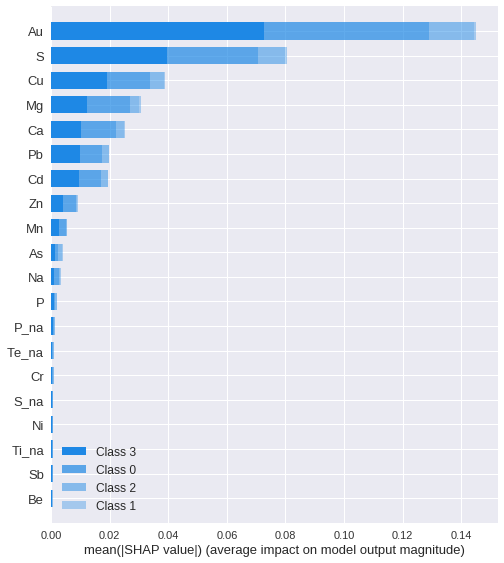

In [0]:
shap.summary_plot(shap_values, x_train, plot_type="bar")


In [0]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Au", shap_values, X)


NameError: ignored

## Predicting aurec

### All info

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# # estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_au, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=1937
- max_features=88
- max_depth=5
- min_samples_split=52
- min_samples_leaf=2


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_au, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=res_gp.x[0], max_features=res_gp.x[1], max_depth = res_gp.x[2], 
                           min_samples_split = res_gp.x[3], min_samples_leaf = res_gp.x[4], n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

1.286904997539059 0.01364176928961763 0.11603934674522443


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

       importance
Au       0.836260
K        0.033176
Fe       0.027327
S        0.022083
Cu       0.017584
Te       0.016158
Al       0.008920
Sb       0.007505
As       0.004559
Au_na    0.003650
Ca       0.003197
Ta       0.002985
Mo       0.002312
P        0.002288
W        0.002105
Se_na    0.001946
Pb       0.001101
Cr       0.000859
Cd       0.000810
Mn       0.000712
Zn       0.000571
Na       0.000480
Mg       0.000458
W_na     0.000392
Cr_na    0.000387
Ni       0.000365
Si       0.000349
Ti       0.000204
Ba       0.000134
Y        0.000129
...           ...
Sr_na    0.000000
S_na     0.000000
Ta_na    0.000000
P_na     0.000000
Th_na    0.000000
Tl_na    0.000000
V_na     0.000000
Al_na    0.000000
Ni_na    0.000000
Nb_na    0.000000
Li       0.000000
Nb       0.000000
Re       0.000000
Sr       0.000000
Th       0.000000
As_na    0.000000
B_na     0.000000
Ba_na    0.000000
Be_na    0.000000
Bi_na    0.000000
Ca_na    0.000000
Cd_na    0.000000
Fe_na    0.000000
Hg_na    0

## Predicting agrec

### Random Forest

In [0]:
# initial rf model
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(10,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_ag, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=960
- max_features=53
- max_depth=4
- min_samples_split=2
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_ag, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=res_gp.x[0], max_features=res_gp.x[1], max_depth = res_gp.x[2], 
                           min_samples_split = res_gp.x[3], min_samples_leaf = res_gp.x[4], n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))
    
    



2.2737376228544406 0.03466100759994516 0.18596603002102324


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

       importance
Au       0.431592
Cu       0.239509
S        0.047413
Mn       0.037822
As       0.036647
Ca       0.033787
Sb       0.021166
Fe       0.018381
Be       0.016239
Cd       0.014230
Pb       0.011871
Zn       0.011489
Mg       0.010002
Al       0.007312
P        0.006445
K        0.005683
Mo       0.005293
Na       0.004474
Ni       0.004303
Bi       0.004300
Cr       0.003647
Ti       0.003632
V        0.003195
Tl       0.002577
U        0.001981
Te       0.001964
Si       0.001605
B        0.001535
Zr       0.001284
Se_na    0.001007
...           ...
As_na    0.000069
Mg_na    0.000066
Cu_na    0.000060
Re_na    0.000056
S_na     0.000056
Be_na    0.000052
Hg_na    0.000044
Sb_na    0.000041
Tl_na    0.000040
Sn       0.000039
Pd_na    0.000034
Mn_na    0.000032
Li_na    0.000031
Sc       0.000026
Ni_na    0.000026
Sr_na    0.000021
Th_na    0.000021
V_na     0.000020
Zr_na    0.000020
Mo_na    0.000019
Ba_na    0.000017
Na_na    0.000016
Fe_na    0.000014
Y_na     0

## Predicting nacnc

### All info

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [0]:
# defining search space
space = [Integer(100,2000, name='n_estimators'),
         Integer(1, n_features, name='max_features'),
         Integer(1, 5, name='max_depth'),
         Integer(2, 100, name='min_samples_split'),
         Integer(1, 100, name='min_samples_leaf')]


In [0]:
# estimator parameters
# @use_named_args(space)
# def objective(**params):
#     m.set_params(**params)

#     return -np.mean(cross_val_score(m, df_all, y_nac, cv=5, n_jobs=-1,
#                                     scoring="neg_mean_squared_error"))

In [0]:
# trying a different objective function
@use_named_args(space)
def objective(**params):
    m.set_params(**params)
    i = 0
    l_rmse=[]
    while i<10:
        x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
        i+=1

    return np.mean(l_rmse)

In [0]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
#instead of gp_minimize can also use forest_minimize or gbrt_minimize

%time res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


"Best score=%.4f" % res_gp.fun

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 28min 41s, sys: 2min 24s, total: 31min 6s
Wall time: 21min 29s


'Best score=1.7564'

In [0]:
# print("""Best parameters:
# - n_estimators=%d
# - max_features=%d
# - max_depth=%d
# - min_samples_split=%d
# - min_samples_leaf=%d
# - criterion = %s""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3], 
#                             res_gp.x[4], res_gp.x[5]))

print("""Best parameters:
- n_estimators=%d
- max_features=%d
- max_depth=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- n_estimators=100
- max_features=57
- max_depth=5
- min_samples_split=2
- min_samples_leaf=1


In [0]:
i = 0
l_rmspe = []
l_mse = []
l_rmse=[]

while i <10:
    x_train, x_test, y_train, y_test = train_test_split(df_all, y_nac, test_size = 0.2)
    m = RandomForestRegressor(n_estimators=res_gp.x[0], max_features=res_gp.x[1], max_depth = res_gp.x[2],
                              min_samples_split = res_gp.x[3], min_samples_leaf=res_gp.x[4],
                              n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    l_rmspe.append(rmspe(preds, y_test))
    l_mse.append(mean_squared_error(preds, y_test))
    l_rmse.append(math.sqrt(mean_squared_error(preds, y_test)))
    i+=1

print(np.mean(l_rmspe), np.mean(l_mse), np.mean(l_rmse))

10.738613303836155 3.2574685427504675 1.8035676318487366


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

         importance
Au     5.279943e-01
Si     1.125812e-01
Cr     1.033664e-01
Sb     5.100049e-02
Na     4.052737e-02
Cu     2.987694e-02
Bi     2.530791e-02
Ni     9.466079e-03
Pb     8.312653e-03
As     6.735348e-03
Fe     6.120890e-03
Zn     5.841035e-03
Pd     5.538000e-03
Ti     5.301328e-03
Hg     5.247688e-03
P      5.062125e-03
Mo     4.685854e-03
Mn     4.487538e-03
Cd     4.401127e-03
Ca     3.839428e-03
S      3.689766e-03
Al     3.680112e-03
Be     2.988613e-03
K      2.498622e-03
Mg     1.598747e-03
Te     1.504320e-03
B_na   1.481831e-03
Tl     1.345456e-03
Au_na  1.318773e-03
Ba_na  1.244228e-03
...             ...
Sc_na  1.748098e-05
La     1.729565e-05
U_na   1.402341e-05
Ta_na  1.348738e-05
Ca_na  1.234979e-05
Si_na  9.937605e-06
Hg_na  8.833529e-06
Te_na  3.393763e-06
Fe_na  3.218255e-06
Sc     1.824906e-06
Co_na  1.350642e-07
Pb_na  0.000000e+00
Th_na  0.000000e+00
Zn_na  0.000000e+00
Y_na   0.000000e+00
W_na   0.000000e+00
Ta     0.000000e+00
Th     0.000000e+00


## Observations

RMSPE is almost 5% higher than other tests, but RMSE is around the same

Can be explained by RMSPE uses $\sqrt{\sum_{i=1}^{n}{(\dfrac{\hat{y}_i-y_i}{y_i}})^2}$  and RMSE uses $\sqrt{\sum_{i=1}^{n}{(\hat{y}_i-y_i)^2}}$.

RMSE penalize the squared difference between $y_i$ and $\hat{y}_i$ equally whereas RMSPE will incur a higher penalty if $y_i$ is lower

E.g. RMSE will incurr the same loss for $y_i = 10, \hat{y}_i = 9$ and $y_i = 2, \hat{y}_i = 1$ (both will have RMSE of 1) whereas RMSPE incurrs higher loss for $y_i = 2, \hat{y}_i = 1$ (RMSPE of 0.5) than $y_i = 10, \hat{y}_i = 9$ (RMSPE of 0.1)

